# Solar Wind Models

The standard solar wind model in PINT is implemented as the `NE_SW` parameter ([Edwards et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006MNRAS.372.1549E/abstract)), which is the solar wind electron density at 1 AU (in cm$^{-3}$).  This assumes that the electron density falls as $r^{-2}$ away from the Sun.  With `SWM=0` this is all that is allowed.

However, in [You et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007ApJ...671..907Y/abstract) and [You et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.422.1160Y/abstract), they extend the model to other radial power-law indices $r^{-p}$ (also see [Hazboun et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022ApJ...929...39H/abstract)).  This is now implemented with `SWM=1` in PINT (and the power-law index is `SWP`).

Finally, it is clear that the solar wind model can vary from year to year (or even over shorter timescales).  Therefore we now have a new `SWX` model (like `DMX`) that implements a separate solar wind model over different time intervals.

With the new model, though, there is covariance between the power-law index `SWP` and `NE_SW`, since most of the fit is determined by the maximum excess DM in the data.  Therefore for the `SWX` model we have reparameterized it to use `SWXDM`: the max DM at conjunction.  This makes the covariance a lot less.  And to ensure continuity, this is explicitly the **excess** DM, so the DM from the `SWX` model at opposition is 0.

In [1]:
from io import StringIO
import numpy as np

from astropy.time import Time
import astropy.coordinates
from pint.models import get_model
from pint.fitter import Fitter
from pint.simulation import make_fake_toas_uniform
import pint.utils
import pint.gridutils
import pint.logging

import matplotlib.pyplot as plt

pint.logging.setup(level="WARNING")

1

## Demonstrate the change in covariance going from NE_SW to DMMAX

In [2]:
par = """
PSR J1234+5678
F0 1
DM 10
ELAT 3
ELONG 0
PEPOCH 54000
EPHEM DE440
"""

In [3]:
# basic model using standard SW
model0 = get_model(StringIO("\n".join([par, "NE_SW 30\nSWM 0"])))

In [4]:
toas = pint.simulation.make_fake_toas_uniform(
    54000,
    54000 + 365,
    153,
    model=model0,
    obs="gbt",
    add_noise=True,
)

In [5]:
# standard model with variable index
model1 = get_model(StringIO("\n".join([par, "NE_SW 30\nSWM 1\nSWP 2"])))
# SWX model with 1 segment
model2 = get_model(
    StringIO(
        "\n".join(
            [par, "SWXDM_0001 1\nSWXP_0001 2\nSWXR1_0001 53999\nSWXR2_0001 55000"]
        )
    )
)
model2.SWXDM_0001.quantity = model0.get_max_dm()

In [6]:
# parameter grids
p = np.linspace(1.5, 2.5, 13)

ne_sw = model0.NE_SW.quantity * np.linspace(0.5, 1.5, 15)
dmmax = np.linspace(0.5, 1.5, len(ne_sw)) * model0.get_max_dm()

In [7]:
f1 = Fitter.auto(toas, model1)
chi2_SWM1 = pint.gridutils.grid_chisq(f1, ("NE_SW", "SWP"), (ne_sw, p))[0]

In [8]:
f2 = Fitter.auto(toas, model2)
chi2_SWX = pint.gridutils.grid_chisq(f2, ("SWXDM_0001", "SWXP_0001"), (dmmax, p))[0]

Text(0.5, 0, 'NE_SW or DMMAX / best-fit')

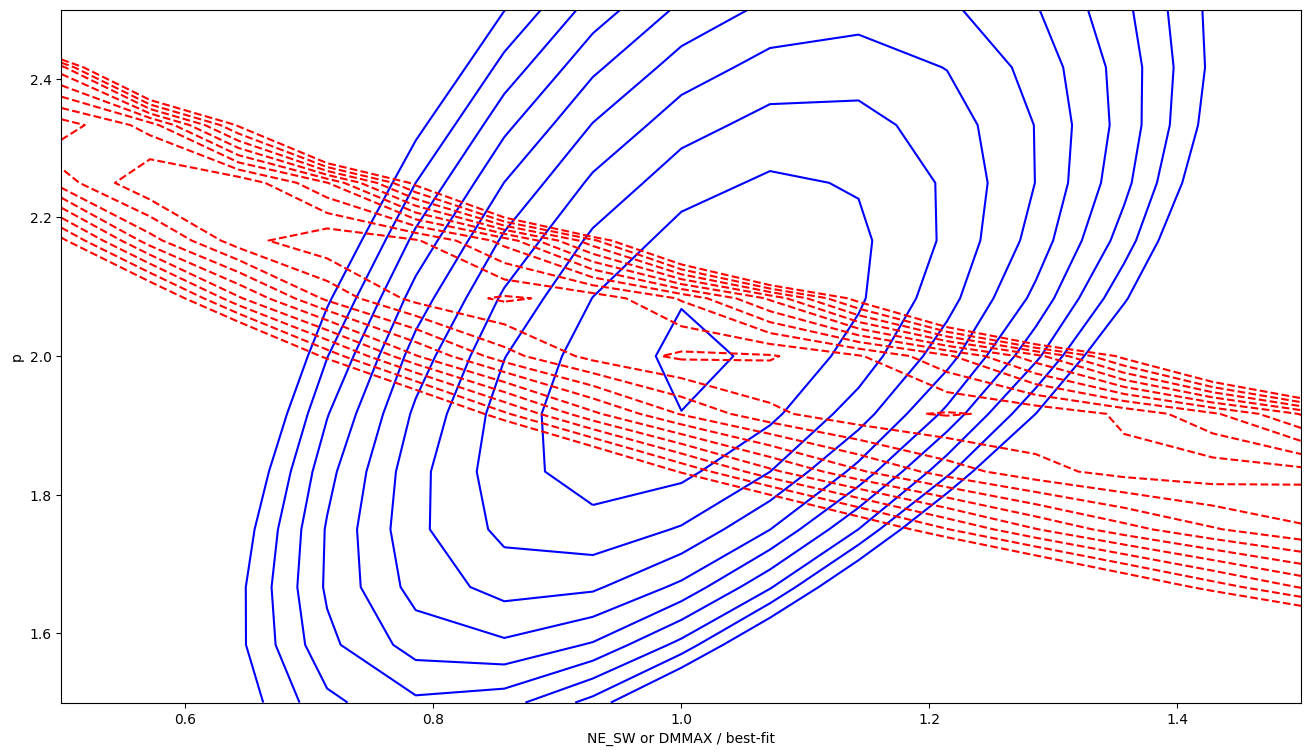

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.contour(
    dmmax / model0.get_max_dm(),
    p,
    chi2_SWX - chi2_SWX.min(),
    np.linspace(2, 100, 10),
    colors="b",
)
ax.contour(
    ne_sw / model0.NE_SW.quantity,
    p,
    chi2_SWM1 - chi2_SWM1.min(),
    np.linspace(2, 100, 10),
    colors="r",
    linestyles="--",
)
ax.set_ylabel("p")
ax.set_xlabel("NE_SW or DMMAX / best-fit")

## SW model limits & scalings

With the new `SWX` model, since it is only excess DM that starts at 0, in order to make the new model agree with the old you may need to scale some quantities

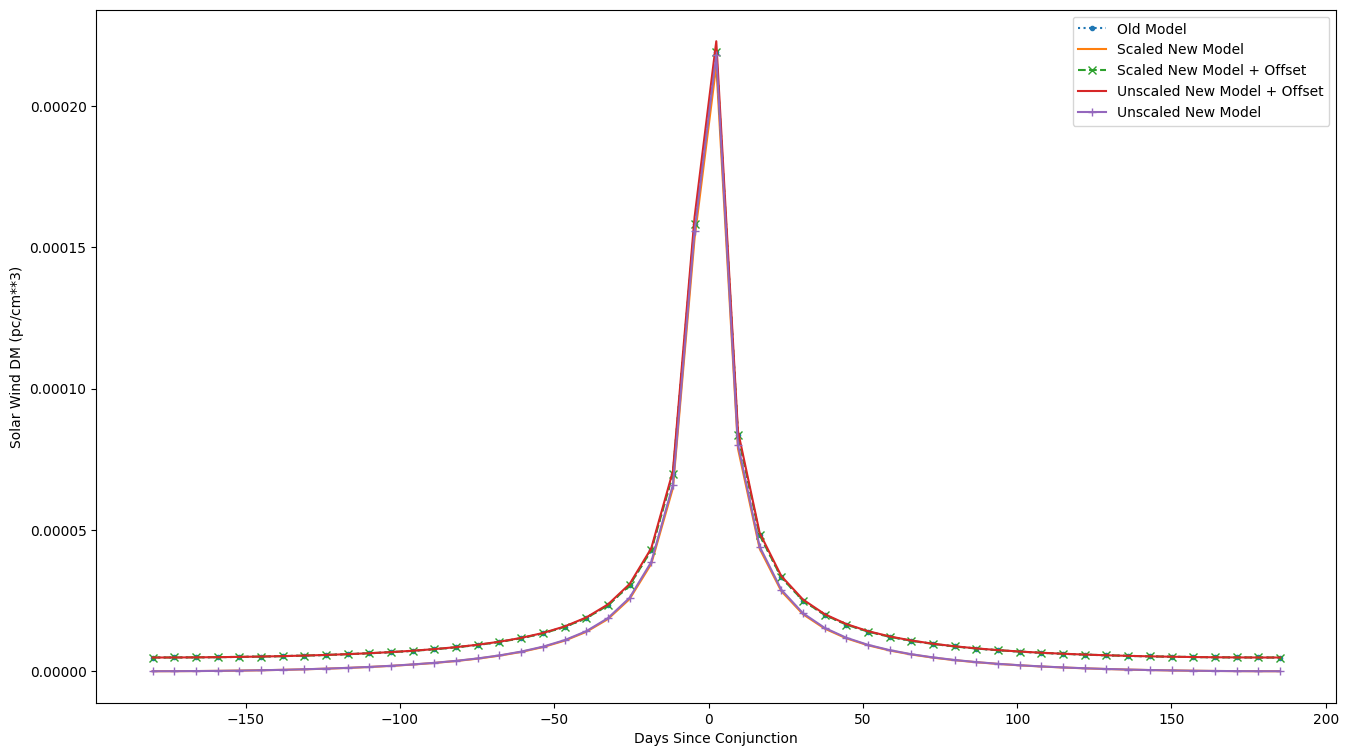

In [10]:
# default model
model = get_model(StringIO("\n".join([par, "NE_SW 1"])))
# SWX model with a single segment to match the default model
model2 = get_model(
    StringIO(
        "\n".join(
            [par, "SWXDM_0001 1\nSWXP_0001 2\nSWXR1_0001 53999\nSWXR2_0001 55000"]
        )
    )
)
# because of the way SWX is scaled, scale the input
scale = model2.get_swscalings()[0]
model2.SWXDM_0001.quantity = model.get_max_dm() * scale
toas = make_fake_toas_uniform(54000, 54000 + 365.25, 53, model=model, obs="gbt")

t0, elongation = pint.utils.get_conjunction(
    model.get_psr_coords(),
    Time(54000, format="mjd"),
    precision="high",
)

x = toas.get_mjds().value - t0.mjd
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(x, model.solar_wind_dm(toas), ".:", label="Old Model")
ax.plot(x, model2.swx_dm(toas), label="Scaled New Model")
ax.plot(
    x,
    model2.swx_dm(toas) + model.get_min_dm(),
    "x--",
    label="Scaled New Model + Offset",
)
model2.SWXDM_0001.quantity = model.get_max_dm()
ax.plot(
    x,
    model2.swx_dm(toas) + model.get_min_dm(),
    label="Unscaled New Model + Offset",
)
ax.plot(
    x,
    model2.swx_dm(toas),
    "+-",
    label="Unscaled New Model",
)
ax.set_xlabel("Days Since Conjunction")
ax.set_ylabel("Solar Wind DM (pc/cm**3)")
ax.legend()

## Utility functions

A few functions to help move between models or separate model `SWX` segments

### Find the next conjunction (time of SW max)
The `low` precision version just interpolates the Sun's ecliptic longitude to match that of the pulsar.  The `high` precision version uses better coordinate conversions to do this.  It also returns the elongation at conjunction

In [11]:
t0, elongation = pint.utils.get_conjunction(
    model.get_psr_coords(),
    Time(54000, format="mjd"),
    precision="high",
)
print(f"Next conjunction at {t0}, with elongation {elongation}")

Next conjunction at 54180.109614738816, with elongation 2.9999638108834428 deg


As expected, the elongation is just about 3 degrees (the ecliptic latitude of the pulsar)

### Divide the input times (TOAs) into years centered on each conjunction
This returns integer indices for each year

Text(0, 0.5, 'Elongation (deg)')

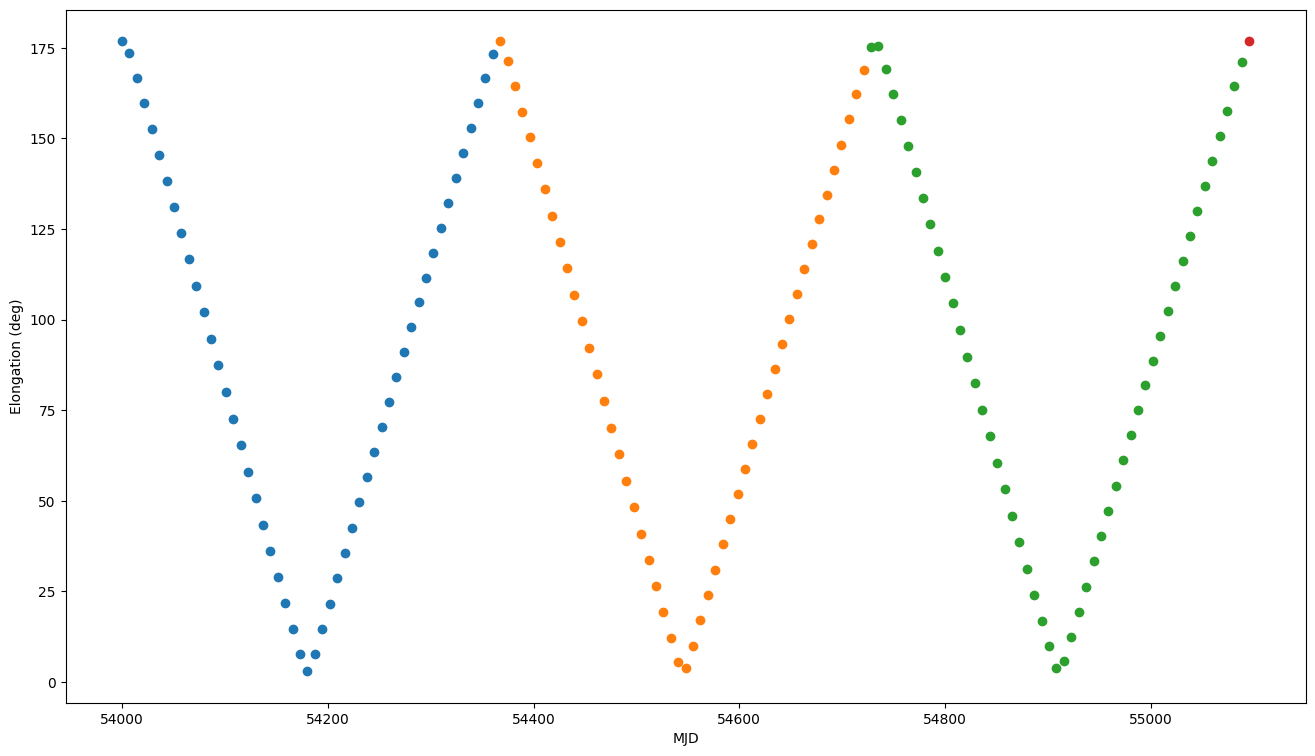

In [12]:
toas = make_fake_toas_uniform(54000, 54000 + 365.25 * 3, 153, model=model, obs="gbt")
elongation = astropy.coordinates.get_sun(
    Time(toas.get_mjds(), format="mjd")
).separation(model.get_psr_coords())
t0 = pint.utils.get_conjunction(
    model.get_psr_coords(), model.PEPOCH.quantity, precision="high"
)[0]
indices = pint.utils.divide_times(Time(toas.get_mjds(), format="mjd"), t0)
fig, ax = plt.subplots(figsize=(16, 9))
for i in np.unique(indices):
    ax.plot(toas.get_mjds()[indices == i], elongation[indices == i].value, "o")
ax.set_xlabel("MJD")
ax.set_ylabel("Elongation (deg)")

### Get max/min DM from standard model, or NE_SW from SWX model

In [13]:
model0 = get_model(StringIO("\n".join([par, "NE_SW 30\nSWM 0"])))
# standard model with variable index
model1 = get_model(StringIO("\n".join([par, "NE_SW 30\nSWM 1\nSWP 2.5"])))
# SWX model with 1 segment
model2 = get_model(
    StringIO(
        "\n".join(
            [par, "SWXDM_0001 1\nSWXP_0001 2\nSWXR1_0001 53999\nSWXR2_0001 55000"]
        )
    )
)
# one value of the scale is returned for each SWX segment
scale = model2.get_swscalings()[0]
print(f"SW scaling: {scale}")
model2.SWXDM_0001.quantity = model0.get_max_dm() * scale

SW scaling: 0.9830510553813481


In [14]:
# Max is at conjunction, Min at opposition
print(
    f"SWM=0: NE_SW = {model0.NE_SW.quantity:.2f} Max DM = {model0.get_max_dm():.4f}, Min DM = {model0.get_min_dm():.4f}"
)
# Max and Min depend on NE_SW and SWP (covariance)
print(
    f"SWM=1 and SWP={model1.SWP.value}:  NE_SW = {model1.NE_SW.quantity:.2f} Max DM = {model1.get_max_dm():.4f}, Min DM = {model1.get_min_dm():.4f}"
)
# For SWX, the max/min values reported do not assume that it goes to 0 at opposition (for compatibility)
print(
    f"SWX and SWP={model2.SWXP_0001.value}: NE_SW = {model2.get_ne_sws()[0]:.2f} Max DM = {model2.get_max_dms()[0]:.4f}, Min DM = {model2.get_min_dms()[0]:.4f}"
)
print(
    f"SWX and SWP={model2.SWXP_0001.value}: Scaled NE_SW = {model2.get_ne_sws()[0]/scale:.2f} Scaled Max DM = {model2.get_max_dms()[0]/scale:.4f}, Scaled Min DM = {model2.get_min_dms()[0]/scale:.4f}"
)

SWM=0: NE_SW = 30.00 1 / cm3 Max DM = 0.0086 pc / cm3, Min DM = 0.0001 pc / cm3
SWM=1 and SWP=2.5:  NE_SW = 30.00 1 / cm3 Max DM = 0.0290 pc / cm3, Min DM = 0.0001 pc / cm3
SWX and SWP=2.0: NE_SW = 29.49 1 / cm3 Max DM = 0.0084 pc / cm3, Min DM = 0.0001 pc / cm3
SWX and SWP=2.0: Scaled NE_SW = 30.00 1 / cm3 Scaled Max DM = 0.0086 pc / cm3, Scaled Min DM = 0.0001 pc / cm3


The scaled values above agree between the `SWM=0` and `SWX` models.